In [11]:
import numpy as np
import matplotlib.pyplot as plt
import platform
import os

from M3RefTracking import M3RefTracking
from DetectorConfigLoader import DetectorConfigLoader
from Detector import Detector
from DreamDetector import DreamDetector
from DreamData import DreamData

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency
from detector_characterization import filter_ray_xy

In [12]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 7  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'ss1_test_12-18-24'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'long_run_1'

det_single = 'strip_strip_1'

# file_nums = list(range(0, 10))
file_nums = 'all'

realign_dream = True  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [5, 5]  # mm range to search for optimal z position
z_rot_range = [-5, 5]

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [13]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums)

Getting ray data...


100%|██████████| 20/20 [00:00<00:00, 37.39it/s]


In [14]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [15]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')

print(f'Detector center: {det.center}')
print(f'Detector active size: {det.active_size}')

det.load_dream_data(data_dir, ped_dir, 10, file_nums, chunk_size, save_waveforms=True)
print(f'Hits shape: {det.dream_data.hits.shape}')

FEU Num: 6
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 800, 'resist_2': 450}
Detector center: [  0   0 799]
Detector active size: [130 130   4]
Reading in data...


100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Read in data shape: (27125, 256, 32)
Getting amplitudes...


100%|██████████| 15/15 [00:00<00:00, 44.92it/s]


Fitting time: 0.39651942253112793 s
Processed chunk 1/1
Getting hits...
Hits shape: (27125, 256)


In [16]:
det.make_sub_detectors()
# if realign_dream:
#     det.add_rotation(90, 'z')

Detector center: [  0   0 799]
Detector rotations: []


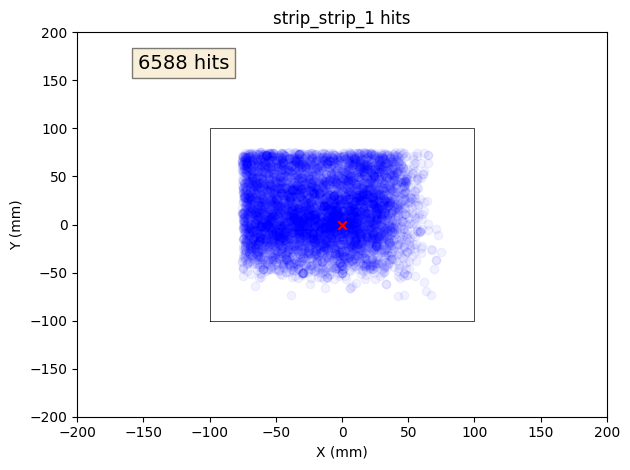

In [17]:
plot_ray_hits_2d(det, ray_data)
print(f'Detector center: {det.center}')
print(f'Detector rotations: {det.rotations}')
old_center = det.center
old_rotations = det.rotations.copy()

z: 709.0
z: 709.3448275862069
z: 709.6896551724138
z: 710.0344827586207
z: 710.3793103448276
z: 710.7241379310345
z: 711.0689655172414
z: 711.4137931034483
z: 711.7586206896551
z: 712.1034482758621
z: 712.448275862069
z: 712.7931034482758
z: 713.1379310344828
z: 713.4827586206897
z: 713.8275862068965
z: 714.1724137931035
z: 714.5172413793103
z: 714.8620689655172
z: 715.2068965517242
z: 715.551724137931
z: 715.8965517241379
z: 716.2413793103449
z: 716.5862068965517
z: 716.9310344827586
z: 717.2758620689655
z: 717.6206896551724
z: 717.9655172413793
z: 718.3103448275862
z: 718.6551724137931
z: 719.0
z_rot: -5.0
z_rot: -4.655172413793103
z_rot: -4.310344827586206
z_rot: -3.9655172413793105
z_rot: -3.6206896551724137
z_rot: -3.275862068965517
z_rot: -2.9310344827586206
z_rot: -2.586206896551724
z_rot: -2.2413793103448274
z_rot: -1.8965517241379306
z_rot: -1.5517241379310343
z_rot: -1.206896551724138
z_rot: -0.8620689655172411
z_rot: -0.5172413793103443
z_rot: -0.1724137931034484
z_rot: 0.17

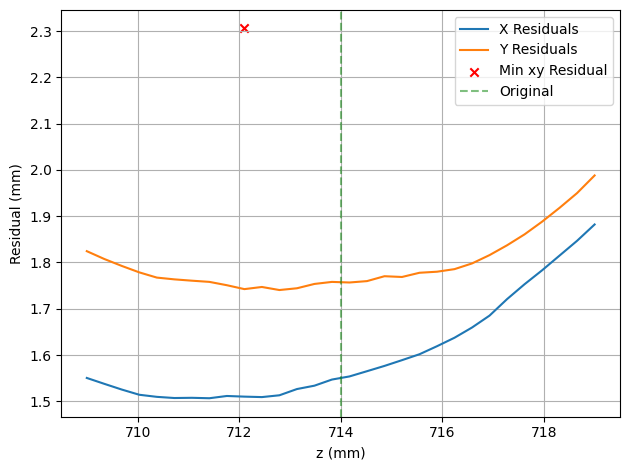

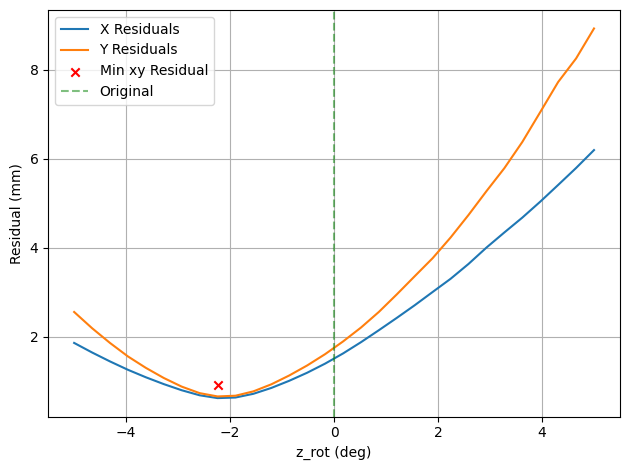

In [18]:
det.center[2] -= 85

x, y, event_nums = ray_data.get_xy_positions(det.center[2])
print(x[:5])
print(y[:5])

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    # det.add_rotation(-90, 'z')
    align_dream(det, ray_data, z_align_range, z_rot_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

Detector center: [ 87.4736411   47.65572047 712.10344828]
Detector rotations: [[-2.2413793103448274, 0, 0]]


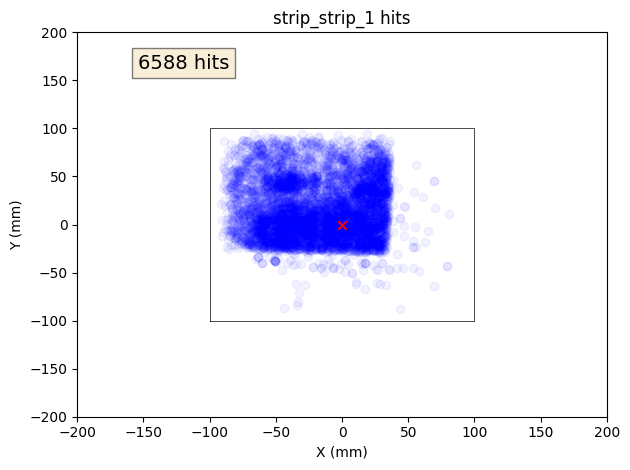

In [19]:
plot_ray_hits_2d(det, ray_data)
print(f'Detector center: {det.center}')
print(f'Detector rotations: {det.rotations}')

Detector center: [  0   0 714]
Detector rotations: []


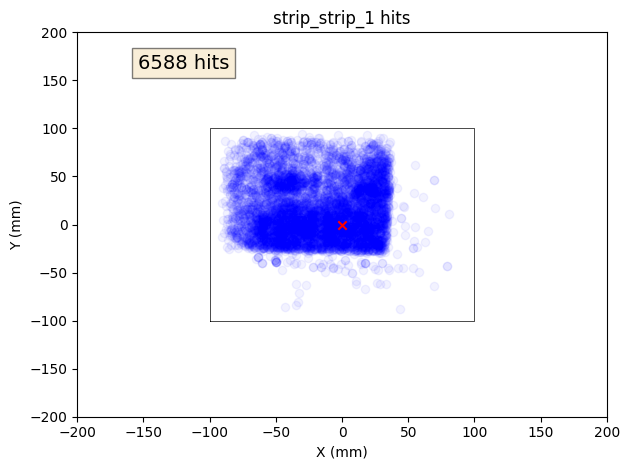

In [20]:
det.center = old_center
det.rotations = old_rotations
plot_ray_hits_2d(det, ray_data)
print(f'Detector center: {det.center}')
print(f'Detector rotations: {det.rotations}')